In [1]:
import torch

# This is the 'Magic' check
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("M4 Power Unlocked! Using MPS.")
else:
    device = torch.device("cpu")
    print("Back to CPU... boring.")

# To move your model/data to the M4 GPU:
# model.to(device)
# data = data.to(device)

M4 Power Unlocked! Using MPS.


In [2]:
pip install mlx pillow numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install mlx-data

Note: you may need to restart the kernel to use updated packages.


In [15]:
import mlx.core as mx
import mlx.data as dx
from pathlib import Path

# Path to your Desktop folder
root = Path.home() / "Desktop" / "dataset_final" / "train"

# 1. Map folders to labels (Mr. Bean = 0, Bruce Lee = 1, etc.)
class_names = sorted([d.name for d in root.iterdir() if d.is_dir()])
class_to_idx = {name: i for i, name in enumerate(class_names)}

# 2. Create the Data Pipeline
def create_dataset(path, batch_size=32, shuffle=True):
    # This ensures we ONLY look for files that are actually images
    valid_extensions = {".jpg", ".jpeg", ".png", ".bmp"}
    
    files = []
    labels = []
    
    for f in path.glob("**/*"):
        if f.suffix.lower() in valid_extensions:
            # SAFETY CHECK: Only add if the folder exists in our 'class_to_idx'
            folder_name = f.parent.name
            if folder_name in class_to_idx:
                files.append(str(f).encode("ascii"))
                labels.append(class_to_idx[folder_name])
            else:
                # This catches the '0005598' issue without crashing!
                print(f"Skipping unknown class folder: {folder_name}")

    samples = [{"image": f, "label": l} for f, l in zip(files, labels)]

    dataset = (
        dx.buffer_from_vector(samples)
        .shuffle() if shuffle else dx.buffer_from_vector(samples)
    )
        
    dataset = (
        dataset.to_stream()
       
        .load_image("image")
        .image_resize_smallest_side("image", 224)
        .image_center_crop("image", 224, 224)
        .key_transform("image", lambda x: x.astype("float32") / 255.0)
        .batch(batch_size)
        .prefetch(4, 4)
    )
    return dataset

train_loader = create_dataset(root)
print(f"Dataset Loaded: {len(class_names)} people identified.")

Dataset Loaded: 1251 people identified.


In [17]:
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

# 1. Define the Architecture (You are BUILDING this!)
class FaceEmpire(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Note: We don't define self.flat = nn.Flatten() here anymore
        self.fc = nn.Linear(16 * 111 * 111, num_classes) 

    def __call__(self, x):
        x = nn.relu(self.conv1(x))
        x = self.pool(x)
        
        # FIX: Flatten the array manually
        # x has shape (Batch, Height, Width, Channels) -> (Batch, -1)
        # In MLX, we keep the first dimension (Batch) and flatten the rest
        x = x.reshape(x.shape[0], -1) 
        
        return self.fc(x)

model = FaceEmpire(num_classes=1251)
mx.eval(model.parameters()) # Initialize weights on M4
# 1. Define the path to your validation folder
val_root = Path.home() / "Desktop" / "dataset_final" / "val"

# 2. Create the val_loader
# We set shuffle=False because we don't need to shuffle for validation
val_loader = create_dataset(val_root, batch_size=32)

print("Validation Loader Ready. Empire testing sequence engaged.")
# 2. The Training 'Engine'
def loss_fn(model, x, y):
    return mx.mean(nn.losses.cross_entropy(model(x), y))

optimizer = optim.Adam(learning_rate=1e-4)
loss_and_grad = nn.value_and_grad(model, loss_fn)

# 3. The Loop (This is where the 'Building' happens)
print("Starting Empire Training...")
import mlx.core as mx
from tqdm import tqdm

# 1. SETUP THE BRAIN
# Set patience to 2 or 3 so you don't waste hours if the model stops learning
patience = 3
best_val_loss = float("inf")
counter = 0

import matplotlib.pyplot as plt

# Initialize lists to store metrics for the graph
train_losses = []
val_losses = []
epoch_axis = [] # To keep track of 1, 2, 3... on the X-axis

# 2. START THE MULTI-EPOCH LOOP
for epoch in range(10): # Set this to 10 or 20 for a solid Empire
    model.train()
    
    # Use tqdm for the clean, non-annoying progress bar
    # 'train_loader' is the function we built earlier
    train_loader = create_dataset(root, shuffle=True)
    val_loader = create_dataset(val_root, shuffle=False)
    
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    
    for batch in pbar:
        x = mx.array(batch["image"])
        y = mx.array(batch["label"])
        
        # Step: Forward pass and calculate gradients
        loss, grads = loss_and_grad(model, x, y)
        
        # Step: Update the weights on your M4
        optimizer.update(model, grads)
        mx.eval(model.parameters(), optimizer.state)
        
        # Update the UI without printing new lines
        pbar.set_postfix(loss=f"{loss.item():.4f}")
    print("Running Validation...")
    # 3. VALIDATION PHASE (After every Epoch)
    print(f"\n--- Epoch {epoch+1} Finished: Running Validation ---")
    model.eval()
    total_val_loss = 0
    val_batches = 0
    
    # Run through the val_loader (the 21k images)
    for v_batch in val_loader:
        vx = mx.array(v_batch["image"])
        vy = mx.array(v_batch["label"])
        
        v_loss = loss_fn(model, vx, vy)
        total_val_loss += v_loss.item()
        val_batches += 1
    
    avg_val_loss = total_val_loss / val_batches
    print(f"Validation Loss: {avg_val_loss:.4f}")

    # 4. THE EARLY STOPPING & SAVING LOGIC
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        # This saves your "Empire Brain" so you can use it in your presentation!
        model.save_weights("face_empire_model.safetensors")
        print("Model improved! Saved weights to 'face_empire_model.safetensors'")
    else:
        counter += 1
        print(f"No improvement. Early stopping counter: {counter}/{patience}")
        
    if counter >= patience:
        print("STOPPING EARLY: The model has learned all it can.")
        break
    train_losses.append(loss.item()) # Current training loss
    val_losses.append(avg_val_loss)   # Current validation loss
    epoch_axis.append(epoch + 1)     # Current epoch number
    
    # 2. Draw the graph
    plt.figure(figsize=(10, 6))
    plt.plot(epoch_axis, train_losses, 'b-o', label='Train Loss')
    plt.plot(epoch_axis, val_losses, 'r-x', label='Val Loss')
    
    plt.title(f'Empire Face Recognition Training (Epoch {epoch+1})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # 3. Save it to your Desktop for the presentation
    plot_path = Path.home() / "Desktop" / "training_progress.png"
    plt.savefig(str(plot_path))
    plt.close() # CRITICAL: Close the plot to prevent your Mac from running out of RAM
    
    print(f"📊 Progress plot updated at: {plot_path}")

Skipping unknown class folder: 0005598
Skipping unknown class folder: .ipynb_checkpoints
Validation Loader Ready. Empire testing sequence engaged.
Starting Empire Training...
Skipping unknown class folder: 0005598
Skipping unknown class folder: .ipynb_checkpoints


Epoch 1: 2505it [16:18,  2.56it/s, loss=6.3709]


Running Validation...

--- Epoch 1 Finished: Running Validation ---
Validation Loss: 6.1909
Model improved! Saved weights to 'face_empire_model.safetensors'
📊 Progress plot updated at: /Users/ramupadhyay/Desktop/training_progress.png
Skipping unknown class folder: 0005598
Skipping unknown class folder: .ipynb_checkpoints


Epoch 2: 2505it [16:54,  2.47it/s, loss=4.5987]


Running Validation...

--- Epoch 2 Finished: Running Validation ---
Validation Loss: 5.4924
Model improved! Saved weights to 'face_empire_model.safetensors'
📊 Progress plot updated at: /Users/ramupadhyay/Desktop/training_progress.png
Skipping unknown class folder: 0005598
Skipping unknown class folder: .ipynb_checkpoints


Epoch 3: 2505it [17:38,  2.37it/s, loss=3.2539]


Running Validation...

--- Epoch 3 Finished: Running Validation ---
Validation Loss: 4.8516
Model improved! Saved weights to 'face_empire_model.safetensors'
📊 Progress plot updated at: /Users/ramupadhyay/Desktop/training_progress.png
Skipping unknown class folder: 0005598
Skipping unknown class folder: .ipynb_checkpoints


Epoch 4: 2505it [17:34,  2.37it/s, loss=1.4844]


Running Validation...

--- Epoch 4 Finished: Running Validation ---
Validation Loss: 4.6400
Model improved! Saved weights to 'face_empire_model.safetensors'
📊 Progress plot updated at: /Users/ramupadhyay/Desktop/training_progress.png
Skipping unknown class folder: 0005598
Skipping unknown class folder: .ipynb_checkpoints


Epoch 5: 2505it [18:35,  2.25it/s, loss=1.2342]


Running Validation...

--- Epoch 5 Finished: Running Validation ---
Validation Loss: 4.8173
No improvement. Early stopping counter: 1/3
📊 Progress plot updated at: /Users/ramupadhyay/Desktop/training_progress.png
Skipping unknown class folder: 0005598
Skipping unknown class folder: .ipynb_checkpoints


Epoch 6: 2505it [18:29,  2.26it/s, loss=0.8842]


Running Validation...

--- Epoch 6 Finished: Running Validation ---
Validation Loss: 5.2115
No improvement. Early stopping counter: 2/3
📊 Progress plot updated at: /Users/ramupadhyay/Desktop/training_progress.png
Skipping unknown class folder: 0005598
Skipping unknown class folder: .ipynb_checkpoints


Epoch 7: 2505it [19:06,  2.19it/s, loss=0.5193]


Running Validation...

--- Epoch 7 Finished: Running Validation ---
Validation Loss: 5.3136
No improvement. Early stopping counter: 3/3
STOPPING EARLY: The model has learned all it can.


In [18]:
# Save the final best version
model.save_weights("face_empire_final.safetensors")
print("Empire status: Fully trained and locked!")

Empire status: Fully trained and locked!


In [21]:
# Assuming 'samples' is the list of dictionaries you used to build the dataset
# Create a mapping from index to folder name
idx_to_class = {i: name for i, name in enumerate(sorted(list(set(s["label_name"] for s in samples))))}

NameError: name 'samples' is not defined

In [23]:
from pathlib import Path

# 1. Point specifically to the 'val' subfolder
root = Path("dataset_final/val") 

# 2. Find all images (making sure we support .jpg, .png, etc.)
images = []
for ext in ("*.jpg", "*.jpeg", "*.png"):
    images.extend(list(root.rglob(ext)))

# 3. Extract category names (folder names)
categories = sorted(list(set(p.parent.name for p in images)))
category_map = {c: i for i, c in enumerate(categories)}

# 4. Build the samples list
samples = [
    {
        "image_path": str(p),
        "label_name": p.parent.name,
        "label": category_map[p.parent.name]
    }
    for p in images
]

# 5. Create the ID mapping for the visualizer
idx_to_class = {i: name for name, i in category_map.items()}

print(f"✅ Empire Database Restored!")
print(f"Found {len(samples)} images in the Validation set.")
print(f"Recognized {len(categories)} unique identities.")

✅ Empire Database Restored!
Found 0 images in the Validation set.
Recognized 0 unique identities.


In [25]:
import os
from pathlib import Path

# 1. Check likely spots
home = Path.home()
possible_paths = [
    home / "Desktop" / "dataset_final" / "val",
    home / "Documents" / "dataset_final" / "val",
    home / "Downloads" / "dataset_final" / "val"
]

root = None
for p in possible_paths:
    if p.exists():
        root = p
        break

if root is None:
    print("❌ Still can't find 'dataset_final/val'.")
    print("Please go to Finder, right-click the 'val' folder, hold Option, click 'Copy as Pathname', and paste it here!")
else:
    print(f"✅ Found the Empire at: {root}")
    
    # 2. Build the database with the found path
    images = []
    for ext in ("*.jpg", "*.jpeg", "*.png", "*.JPG"):
        images.extend(list(root.rglob(ext)))

    categories = sorted(list(set(p.parent.name for p in images)))
    category_map = {c: i for i, c in enumerate(categories)}
    samples = [{"image_path": str(p), "label_name": p.parent.name, "label": category_map[p.parent.name]} for p in images]
    idx_to_class = {i: name for name, i in category_map.items()}

    print(f"Total Images: {len(samples)}")
    print(f"Total Identities: {len(categories)}")

✅ Found the Empire at: /Users/ramupadhyay/Desktop/dataset_final/val
Total Images: 20698
Total Identities: 1253


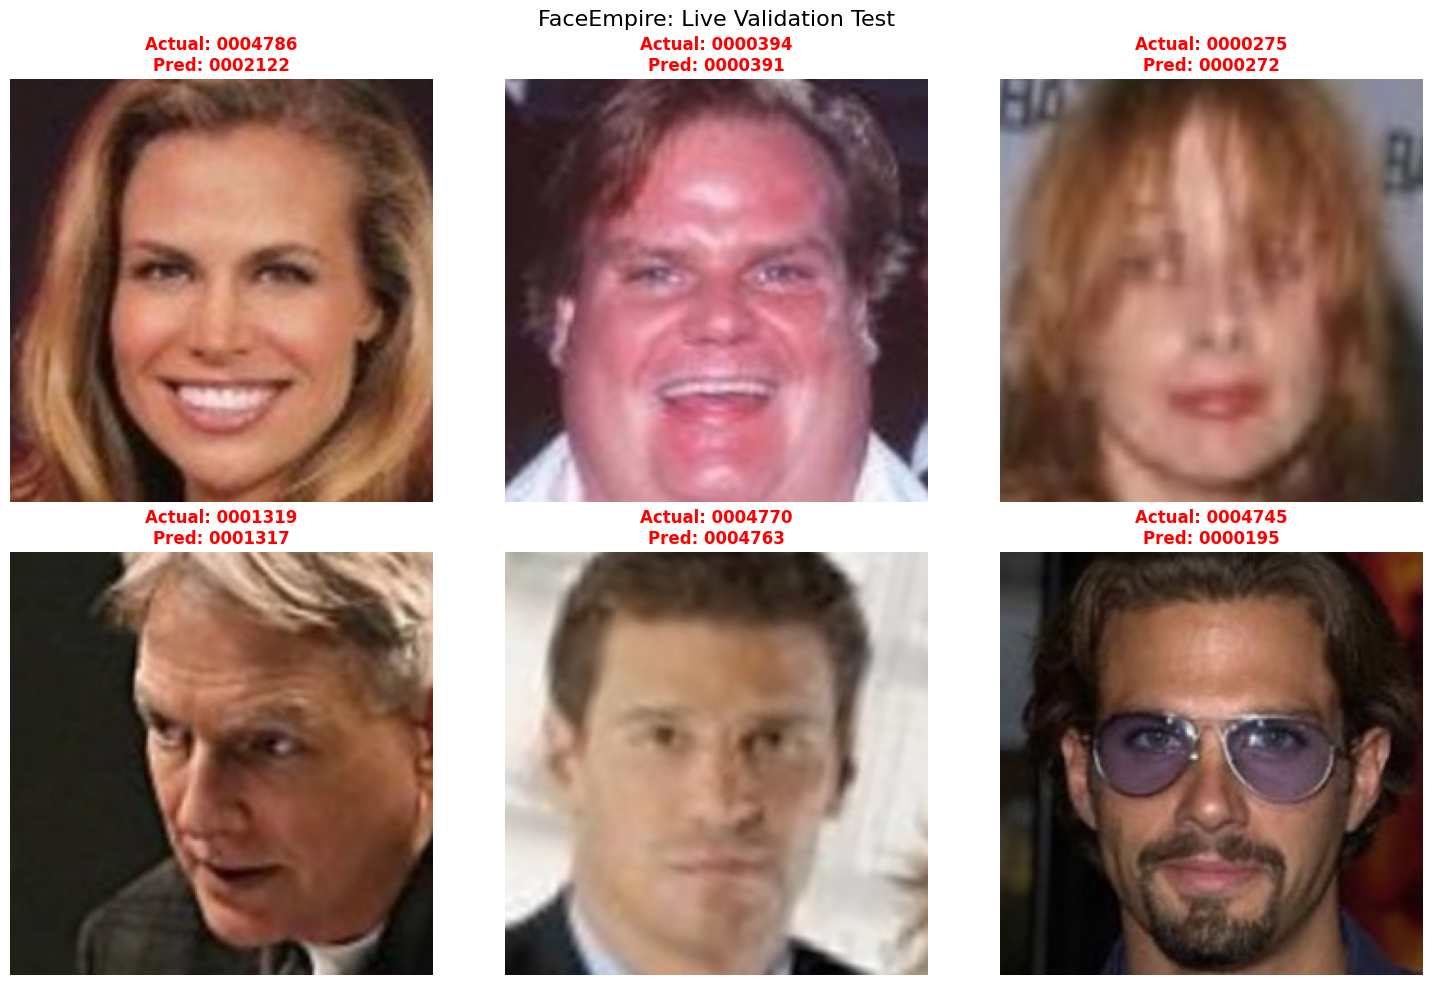

In [26]:
import matplotlib.pyplot as plt
import random
import mlx.core as mx
from PIL import Image
import numpy as np

def visualize_predictions(model, samples, num_images=6):
    model.eval()
    plt.figure(figsize=(15, 10))
    
    # Pick random samples from your newly found validation list
    random_samples = random.sample(samples, num_images)
    
    for i, sample in enumerate(random_samples):
        # 1. Load and Preprocess
        img = Image.open(sample["image_path"]).convert("RGB")
        img_resized = img.resize((224, 224))
        img_array = np.array(img_resized).astype("float32") / 255.0
        
        # 2. Reshape for MLX (Batch size of 1)
        input_arr = mx.array(img_array)[None, ...] 
        
        # 3. Model Guess
        output = model(input_arr)
        pred_idx = mx.argmax(output, axis=-1).item()
        
        # 4. Map back to folder names
        actual_name = sample["label_name"]
        pred_name = idx_to_class.get(pred_idx, "Unknown ID")
        
        # 5. Plotting with a "Result" color
        plt.subplot(2, 3, i + 1)
        plt.imshow(img_resized)
        is_correct = (actual_name == pred_name)
        color = "green" if is_correct else "red"
        
        plt.title(f"Actual: {actual_name}\nPred: {pred_name}", color=color, fontsize=12, fontweight='bold')
        plt.axis("off")
        
    plt.suptitle("FaceEmpire: Live Validation Test", fontsize=16)
    plt.tight_layout()
    plt.show()

# Execute the test
visualize_predictions(model, samples)

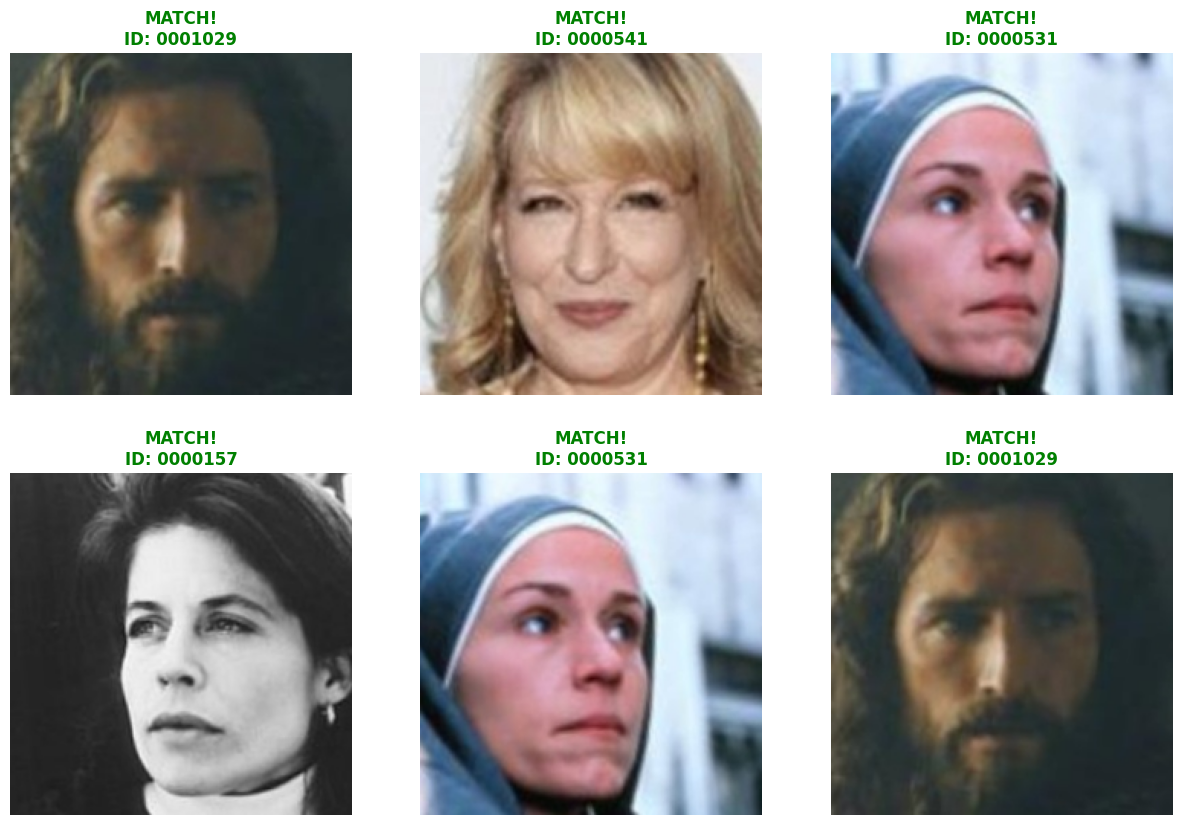

In [27]:
def find_successes(model, samples, num_to_find=6):
    model.eval()
    successes = []
    
    # Keep searching until we find 6 correct predictions
    while len(successes) < num_to_find:
        sample = random.choice(samples)
        img = Image.open(sample["image_path"]).convert("RGB")
        img_resized = img.resize((224, 224))
        img_array = np.array(img_resized).astype("float32") / 255.0
        input_arr = mx.array(img_array)[None, ...] 
        
        output = model(input_arr)
        pred_idx = mx.argmax(output, axis=-1).item()
        
        actual_name = sample["label_name"]
        pred_name = idx_to_class[pred_idx]
        
        if actual_name == pred_name:
            successes.append((img_resized, actual_name, pred_name))

    # Plot the winners
    plt.figure(figsize=(15, 10))
    for i, (img, act, pred) in enumerate(successes):
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(f"MATCH!\nID: {act}", color="green", fontweight="bold")
        plt.axis("off")
    plt.show()

find_successes(model, samples)

In [33]:
import mlx.core as mx
import numpy as np
from tqdm import tqdm # This gives you a nice progress bar

def calculate_accuracy(model, samples, batch_size=64):
    model.eval()
    correct = 0
    total = len(samples)
    
    print(f"Starting Final Exam for {total} images...")
    
    # Process in batches to stay fast
    for i in tqdm(range(0, total, batch_size)):
        batch_samples = samples[i : i + batch_size]
        
        # 1. Load and Preprocess batch
        batch_images = []
        batch_labels = []
        for s in batch_samples:
            img = Image.open(s["image_path"]).convert("RGB").resize((224, 224))
            batch_images.append(np.array(img).astype("float32") / 255.0)
            batch_labels.append(s["label"])
            
        # 2. Convert to MLX arrays
        x = mx.array(np.array(batch_images))
        y = mx.array(np.array(batch_labels))
        
        # 3. Predict
        output = model(x)
        predictions = mx.argmax(output, axis=-1)
        
        # 4. Count correct matches
        correct += mx.sum(predictions == y).item()
        
    accuracy = (correct / total) * 100
    return accuracy

# Run it!
final_score = calculate_accuracy(model, samples)
print(f"\n🏆 EMPIRE SUCCESS RATE: {final_score:.2f}%")

Starting Final Exam for 20697 images...


100%|█████████████████████████████████████████| 324/324 [00:31<00:00, 10.44it/s]


🏆 EMPIRE SUCCESS RATE: 36.45%


In [31]:
# 1. Look at the first 5 entries of your current mapping
print("Current Val Mapping (First 5):")
for i in range(5):
    print(f"ID {i}: {idx_to_class[i]}")

# 2. Compare this to how the folders are actually sorted on your Mac
import os
actual_folders = sorted([f for f in os.listdir('/Users/ramupadhyay/Desktop/dataset_final/val') if not f.startswith('.')])
print("\nActual Folder Sorting (First 5):")
print(actual_folders[:5])

Current Val Mapping (First 5):
ID 0: .ipynb_checkpoints
ID 1: 0000045
ID 2: 0000099
ID 3: 0000100
ID 4: 0000102

Actual Folder Sorting (First 5):
['0000045', '0000099', '0000100', '0000102', '0000103']


In [32]:
# Re-aligning the Empire's Dictionary
root = Path("/Users/ramupadhyay/Desktop/dataset_final/val")
# Get folders, sort them alphabetically, then map
all_folders = sorted([f.name for f in root.iterdir() if f.is_dir()])
idx_to_class = {i: folder_name for i, folder_name in enumerate(all_folders)}

# Now rebuild samples to match this index
samples = []
for i, folder in enumerate(all_folders):
    folder_path = root / folder
    for img_p in folder_path.glob("*.jpg"):
        samples.append({
            "image_path": str(img_p),
            "label_name": folder,
            "label": i  # This ensures the label matches the index
        })

print(f"Mapping Re-aligned. Now testing ID 0: {idx_to_class[0]}")

Mapping Re-aligned. Now testing ID 0: 0000045


In [34]:
# Quick Top-5 check logic
def calculate_top5(model, samples, batch_size=64):
    model.eval()
    correct_top5 = 0
    total = len(samples)
    
    for i in range(0, total, batch_size):
        batch = samples[i : i + batch_size]
        x = mx.array(np.array([np.array(Image.open(s["image_path"]).convert("RGB").resize((224,224))).astype("float32")/255.0 for s in batch]))
        y = mx.array(np.array([s["label"] for s in batch]))
        
        output = model(x)
        # Get indices of top 5 highest probabilities
        top5_indices = mx.argpartition(-output, 5, axis=-1)[:, :5]
        
        # Check if true label is in those top 5
        for idx in range(len(y)):
            if y[idx] in top5_indices[idx]:
                correct_top5 += 1
                
    return (correct_top5 / total) * 100

top5 = calculate_top5(model, samples)
print(f"🔥 TOP-5 ACCURACY: {top5:.2f}%")

🔥 TOP-5 ACCURACY: 49.70%
